# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

# Parameters
class opinion:
    def __init__(self, nu=0.25, sigma=0.02, gamma=1,
        f=lambda x: np.array([0 if abs(xx)>1 else pow(xx,2)*(2*abs(xx)-3)+1 for xx in x])) -> None:
        self.nu=nu
        self.sigma=sigma
        self.gamma=gamma
        self.f=f
    def reset_to_default(self):
        self.nu=0.25
        self.sigma=0.02
        self.gamma=1
        self.f=lambda x: np.array([0 if abs(xx)>1 else pow(xx,2)*(2*abs(xx)-3)+1 for xx in x])
    
    def update_initial_distribution(self,f):
        self.f=f

    def testrun(self,m,n,T=10,
        grid=np.linspace(-1,1,int(1e5))):
        eta=lambda z: np.maximum(0,(1-abs(z)/self.nu))
        dx=2/m
        # sigma=2*dx
        X=np.linspace(-1+0.5*dx,1-0.5*dx,m+1)
        dt=T/(n if n else 1)
        w=self.f(X)
        w=w/sum(w)
        for _ in range(n):
            k=X+0.5*dt*np.array([sum([w[j]*eta(X[j]-x)*(X[j]-x) for j in range(m)]) for x in X])
            X=X+dt*np.array([sum([w[j]*eta(k[j]-x)*(k[j]-x) for j in range(m)]) for x in k])
        return sum([w[i]*np.exp(-pow(grid-X[i],2)/(2*self.sigma**2))/np.sqrt(2*np.pi*self.sigma**2) for i in range(m)])
    
    def two_candidate_run(self,m,dt,L0=-1, R0=1, T=10, alpha=[1, 0.1], plotit=True):
        eta=lambda z: max(0,(1-abs(z)/self.nu))
        dx=2/m
        ksi=np.sqrt(self.sigma**2+self.gamma**2)
        X=np.linspace(-1+0.5*dx,1-0.5*dx,m+1)
        # dt=T/(n if n else 1)
        n=int(T/dt)
        SL=np.empty(n+1)
        SR=np.empty(n+1)
        SL[0]=L0
        SR[0]=R0
        w=self.f(X)
        w=w/sum(w)
        hit=False
        for i in range(n):
            #
            k=X+0.5*dt*np.array([sum([w[j]*eta(X[j]-x)*(X[j]-x) for j in range(m)]) for x in X])
            dX=dt*np.array([sum([w[j]*eta(k[j]-x)*(k[j]-x) for j in range(m)]) for x in k])


            weighted_midpoint=(self.gamma/self.sigma)*(0.5*(SL[i]+SR[i])-X)
            midpoint_l=weighted_midpoint+0.5*(self.sigma/self.gamma)*(SR[i]-SL[i])
            midpoint_r=weighted_midpoint-0.5*(self.sigma/self.gamma)*(SR[i]-SL[i])
            dsl=self.gamma*sum([w[j]*np.exp(-pow(X[j]-SL[i],2)/(2*ksi**2))*\
                (((X[j]-SL[i])/(2*ksi**3))*(1-erf(-midpoint_l[j]/(np.sqrt(2)*ksi)))+\
                (self.gamma**2-self.sigma**2)*np.exp(-midpoint_l[j]**2/(2*ksi**2))/(self.gamma*self.sigma*np.sqrt(8*np.pi)*ksi**2)) for j in range(m)])
            dsr=self.gamma*sum([w[j]*np.exp(-pow(X[j]-SR[i],2)/(2*ksi**2))*\
                (((X[j]-SR[i])/(2*ksi**3))*(1+erf(-midpoint_r[j]/(np.sqrt(2)*ksi)))-\
                (self.gamma**2-self.sigma**2)*np.exp(-midpoint_r[j]**2/(2*ksi**2))/(self.gamma*self.sigma*np.sqrt(8*np.pi)*ksi**2)) for j in range(m)])
            SL_mid=SL[i]+0.5*alpha[0]*dt*dsl
            SR_mid=SR[i]+0.5*alpha[1]*dt*dsr
            
           

            weighted_midpoint=(self.gamma/self.sigma)*(0.5*(SL_mid+SR_mid)-X-0.5*dX)
            midpoint_l=weighted_midpoint+0.5*(self.sigma/self.gamma)*(SR_mid-SL_mid)
            midpoint_r=weighted_midpoint-0.5*(self.sigma/self.gamma)*(SR_mid-SL_mid)
            dsl=self.gamma*sum([w[j]*np.exp(-pow(X[j]+0.5*dX[j]-SL_mid,2)/(2*ksi**2))*\
                (((X[j]+0.5*dX[j]-SL_mid)/(2*ksi**3))*(1-erf(-midpoint_l[j]/(np.sqrt(2)*ksi)))+\
                (self.gamma**2-self.sigma**2)*np.exp(-midpoint_l[j]**2/(2*ksi**2))/(self.gamma*self.sigma*np.sqrt(8*np.pi)*ksi**2)) for j in range(m)])
            dsr=self.gamma*sum([w[j]*np.exp(-pow(X[j]+0.5*dX[j]-SR_mid,2)/(2*ksi**2))*\
                (((X[j]+0.5*dX[j]-SR_mid)/(2*ksi**3))*(1+erf(-midpoint_r[j]/(np.sqrt(2)*ksi)))-\
                (self.gamma**2-self.sigma**2)*np.exp(-midpoint_r[j]**2/(2*ksi**2))/(self.gamma*self.sigma*np.sqrt(8*np.pi)*ksi**2)) for j in range(m)])
            
            if hit and (alpha[0]*dsl>=alpha[1]*dsr):
                dcommon=0.5*(alpha[0]*dsl+alpha[1]*dsr)
                SL[i+1]=SL[i]+dt*dcommon
                SR[i+1]=SR[i]+dt*dcommon
            else:
                if hit: print('Candidates separated at timestep',i)
                hit=False
                SL[i+1]=SL[i]+alpha[0]*dt*dsl
                SR[i+1]=SR[i]+alpha[1]*dt*dsr
                if SL[i+1]>SR[i+1]:
                    common_value=0.5*(SL[i+1]+SR[i+1])
                    SL[i+1]=common_value
                    SR[i+1]=common_value
                    hit=True
                    print('Candidates met at timestep',i)
            X=X+dX
            
        time=np.linspace(0,n*dt,n+1)
        if plotit:
            plt.figure()
            plt.plot(time,SL,label='L')
            plt.plot(time,SR,label='R')
            plt.xlim(0,T)
            plt.legend()
        
        return SL,SR, time

    def three_candidate_run(self,m,dt,L0=-1, M0=0, R0=1, T=10, alpha=[1,0.4,0.4],plotit=True):
        eta=lambda z: max(0,(1-abs(z)/self.nu))
        dx=2/m
        ksi=np.sqrt(self.sigma**2+self.gamma**2)
        X=np.linspace(-1+0.5*dx,1-0.5*dx,m+1)
        #dt=T/(n if n else 1)
        n=int(T/dt)
        SL=np.empty(n+1)
        SM=np.empty(n+1)
        SR=np.empty(n+1)
        SL[0]=L0
        SM[0]=M0
        SR[0]=R0
        w=self.f(X)
        w=w/sum(w)

        hit=[False, False]
        for i in range(n):
            #
            k=X+0.5*dt*np.array([sum([w[j]*eta(X[j]-x)*(X[j]-x) for j in range(m)]) for x in X])
            dX=dt*np.array([sum([w[j]*eta(k[j]-x)*(k[j]-x) for j in range(m)]) for x in k])


            weighted_midpoint_lm=(self.gamma/self.sigma)*(0.5*(SL[i]+SM[i])-X)
            weighted_midpoint_mr=(self.gamma/self.sigma)*(0.5*(SM[i]+SR[i])-X)
            midpoint_l =weighted_midpoint_lm +0.5*(self.sigma/self.gamma)*(SM[i]-SL[i])
            midpoint_ml=weighted_midpoint_lm -0.5*(self.sigma/self.gamma)*(SM[i]-SL[i])
            midpoint_mr=weighted_midpoint_mr +0.5*(self.sigma/self.gamma)*(SR[i]-SM[i])
            midpoint_r =weighted_midpoint_mr -0.5*(self.sigma/self.gamma)*(SR[i]-SM[i])
            dsl=self.gamma*sum([w[j]*np.exp(-pow(X[j]-SL[i],2)/(2*ksi**2))*\
                (((X[j]-SL[i])/(2*ksi**3))*(1-erf(-midpoint_l[j]/(np.sqrt(2)*ksi)))+\
                (self.gamma**2-self.sigma**2)*np.exp(-midpoint_l[j]**2/(2*ksi**2))/(self.gamma*self.sigma*np.sqrt(8*np.pi)*ksi**2)) for j in range(m)])
            dsm=self.gamma*sum([w[j]*np.exp(-pow(X[j]-SM[i],2)/(2*ksi**2))*\
                (((X[j]-SM[i])/(2*ksi**3))*(erf(-midpoint_ml[j]/(np.sqrt(2)*ksi))-erf(-midpoint_mr[j]/(np.sqrt(2)*ksi)))+\
                (self.gamma**2-self.sigma**2)*(np.exp(-midpoint_ml[j]**2/(2*ksi**2))-np.exp(-midpoint_mr[j]**2/(2*ksi**2)))/(self.gamma*self.sigma*np.sqrt(8*np.pi)*ksi**2)) for j in range(m)])
                
            dsr=self.gamma*sum([w[j]*np.exp(-pow(X[j]-SR[i],2)/(2*ksi**2))*\
                (((X[j]-SR[i])/(2*ksi**3))*(1+erf(-midpoint_r[j]/(np.sqrt(2)*ksi)))-\
                (self.gamma**2-self.sigma**2)*np.exp(-midpoint_r[j]**2/(2*ksi**2))/(self.gamma*self.sigma*np.sqrt(8*np.pi)*ksi**2)) for j in range(m)])
            SL_mid=SL[i]+0.5*alpha[0]*dt*dsl
            SM_mid=SM[i]+0.5*alpha[1]*dt*dsm
            SR_mid=SR[i]+0.5*alpha[2]*dt*dsr
            
           

            weighted_midpoint_lm=(self.gamma/self.sigma)*(0.5*(SL_mid+SM_mid)-X-0.5*dX)
            weighted_midpoint_mr=(self.gamma/self.sigma)*(0.5*(SM_mid+SR_mid)-X-0.5*dX)
            midpoint_l =weighted_midpoint_lm +0.5*(self.sigma/self.gamma)*(SM_mid-SL_mid)
            midpoint_ml=weighted_midpoint_lm -0.5*(self.sigma/self.gamma)*(SM_mid-SL_mid)
            midpoint_mr=weighted_midpoint_mr +0.5*(self.sigma/self.gamma)*(SR_mid-SM_mid)
            midpoint_r =weighted_midpoint_mr -0.5*(self.sigma/self.gamma)*(SR_mid-SM_mid)
            dsl=self.gamma*sum([w[j]*np.exp(-pow(X[j]+0.5*dX[j]-SL_mid,2)/(2*ksi**2))*\
                (((X[j]+0.5*dX[j]-SL_mid)/(2*ksi**3))*(1-erf(-midpoint_l[j]/(np.sqrt(2)*ksi)))+\
                (self.gamma**2-self.sigma**2)*np.exp(-midpoint_l[j]**2/(2*ksi**2))/(self.gamma*self.sigma*np.sqrt(8*np.pi)*ksi**2)) for j in range(m)])
            dsm=self.gamma*sum([w[j]*np.exp(-pow(X[j]+0.5*dX[j]-SM_mid,2)/(2*ksi**2))*\
                (((X[j]+0.5*dX[j]-SM_mid)/(2*ksi**3))*(erf(-midpoint_ml[j]/(np.sqrt(2)*ksi))-erf(-midpoint_mr[j]/(np.sqrt(2)*ksi)))+\
                (self.gamma**2-self.sigma**2)*(np.exp(-midpoint_ml[j]**2/(2*ksi**2))-np.exp(-midpoint_mr[j]**2/(2*ksi**2)))/(self.gamma*self.sigma*np.sqrt(8*np.pi)*ksi**2)) for j in range(m)])
            dsr=self.gamma*sum([w[j]*np.exp(-pow(X[j]+0.5*dX[j]-SR_mid,2)/(2*ksi**2))*\
                (((X[j]+0.5*dX[j]-SR_mid)/(2*ksi**3))*(1+erf(-midpoint_r[j]/(np.sqrt(2)*ksi)))-\
                (self.gamma**2-self.sigma**2)*np.exp(-midpoint_r[j]**2/(2*ksi**2))/(self.gamma*self.sigma*np.sqrt(8*np.pi)*ksi**2)) for j in range(m)])
             
            if not any(hit):
                SL[i+1]=SL[i]+alpha[0]*dt*dsl
                SM[i+1]=SM[i]+alpha[1]*dt*dsm
                SR[i+1]=SR[i]+alpha[2]*dt*dsr
                if SL[i+1]>SR[i+1]:
                    common_value=(SL[i+1]+SM[i+1]+SR[i+1])/3
                    SL[i+1]=common_value
                    SM[i+1]=common_value
                    SR[i+1]=common_value
                    hit=[True, True]
                    print('All met at timestep', i)
                elif SL[i+1]>SM[i+1]:
                    common_value=(SL[i+1]+SM[i+1])/2
                    SL[i+1]=common_value
                    SM[i+1]=common_value
                    hit[0]=True
                    print('LM met at timestep', i)
                elif SM[i+1]>SR[i+1]:
                    common_value=(SM[i+1]+SR[i+1])/2
                    SM[i+1]=common_value
                    SR[i+1]=common_value
                    hit[1]=True
                    print('MR met at timestep', i)
            elif all(hit): 
                if alpha[0]*dsl>=alpha[2]*dsr:
                    dcommon=(alpha[0]*dsl+alpha[1]*dsm+alpha[2]*dsr)/3 
                    SL[i+1]=SL[i]+dt*dcommon
                    SM[i+1]=SM[i]+dt*dcommon
                    SR[i+1]=SR[i]+dt*dcommon 
                elif alpha[0]*dsl>=alpha[1]*dsm:
                    dcommon=(alpha[0]*dsl+alpha[1]*dsm)/2 
                    SL[i+1]=SL[i]+dt*dcommon
                    SM[i+1]=SM[i]+dt*dcommon
                    SR[i+1]=SR[i]+dt*alpha[2]*dsr
                    hit[1]=False
                    print('R separated from LM at timestep', i)
                elif alpha[1]*dsm>=alpha[2]*dsr:
                    dcommon=(alpha[1]*dsm+alpha[2]*dsr)/2 
                    SL[i+1]=SL[i]+dt*alpha[0]*dsl
                    SM[i+1]=SM[i]+dt*dcommon
                    SR[i+1]=SR[i]+dt*dcommon
                    hit[0]=False
                    print('L separated from MR at timestep', i)
                else:
                    SL[i+1]=SL[i]+dt*alpha[0]*dsl
                    SM[i+1]=SM[i]+dt*alpha[1]*dsm
                    SR[i+1]=SR[i]+dt*alpha[2]*dsr
                    hit=[False, False]
                    print('All separated at timestep', i)
            elif hit[0]:
                if alpha[0]*dsl>=alpha[1]*dsm:
                    dcommon=(alpha[0]*dsl+alpha[1]*dsm)/2 
                    SL[i+1]=SL[i]+dt*dcommon
                    SM[i+1]=SM[i]+dt*dcommon
                    SR[i+1]=SR[i]+dt*alpha[2]*dsr
                    if SM[i+1]>SR[i+1]:
                        common_value=(SL[i+1]+SM[i+1]+SR[i+1])/3
                        SL[i+1]=common_value
                        SM[i+1]=common_value
                        SR[i+1]=common_value
                        hit[1]=True
                        print('All met at timestep', i)
                else:
                    SL[i+1]=SL[i]+alpha[0]*dt*dsl
                    SM[i+1]=SM[i]+alpha[1]*dt*dsm
                    SR[i+1]=SR[i]+alpha[2]*dt*dsr
                    if SM[i+1]>SR[i+1]:
                        common_value=(SM[i+1]+SR[i+1])/2
                        SM[i+1]=common_value
                        SR[i+1]=common_value
                        hit[1]=True
                        
                        if SL[i+1]>SM[i+1]:
                            common_value=(SL[i+1]+SM[i+1]+SR[i+1])/3
                            SL[i+1]=common_value
                            SM[i+1]=common_value
                            SR[i+1]=common_value
                            print('All met at timestep', i)
                        else:
                            hit[0]=False
                            print('LM separated and MR met at timestep', i)
                    else:
                        hit[0]=False
                        print('LM separated at timestep', i)
            else: 
                if alpha[1]*dsm>=alpha[2]*dsr:
                    dcommon=(alpha[1]*dsm+alpha[2]*dsr)/2 
                    SL[i+1]=SL[i]+dt*alpha[0]*dsl
                    SM[i+1]=SM[i]+dt*dcommon
                    SR[i+1]=SR[i]+dt*dcommon
                    if SL[i+1]>SM[i+1]:
                        common_value=(SL[i+1]+SM[i+1]+SR[i+1])/3
                        SL[i+1]=common_value
                        SM[i+1]=common_value
                        SR[i+1]=common_value
                        hit[0]=True
                        print('All met at timestep', i)
                else:
                    SL[i+1]=SL[i]+alpha[0]*dt*dsl
                    SM[i+1]=SM[i]+alpha[1]*dt*dsm
                    SR[i+1]=SR[i]+alpha[2]*dt*dsr
                    if SL[i+1]>SM[i+1]:
                        common_value=(SL[i+1]+SM[i+1])/2
                        SL[i+1]=common_value
                        SM[i+1]=common_value
                        hit[0]=True
                                                
                        if SM[i+1]>SR[i+1]:
                            common_value=(SL[i+1]+SM[i+1]+SR[i+1])/3
                            SL[i+1]=common_value
                            SM[i+1]=common_value
                            SR[i+1]=common_value
                            print('All met at timestep', i)
                        else:
                            hit[1]=False
                            print('MR separated and LM met at timestep', i)
                    else:
                        hit[1]=False
                        print('MR separated at timestep', i)
                
                
            X=X+dX
        
        time=np.linspace(0,n*dt,n+1)
        if plotit:
            plt.figure()
            plt.plot(time,SL,label='L')
            plt.plot(time,SM,label='M')
            plt.plot(time,SR,label='R')
            plt.xlim(0,T)
            plt.legend()
        hit_value='All' if all(hit) else 'LM' if hit[0] else 'MR' if hit[1] else 'None'
        print(hit_value, 'are together at the end')
        return SL,SM,SR, time

# Voter Dynamics

save initial conditions
run simulation for T=300
run simulation for T=600


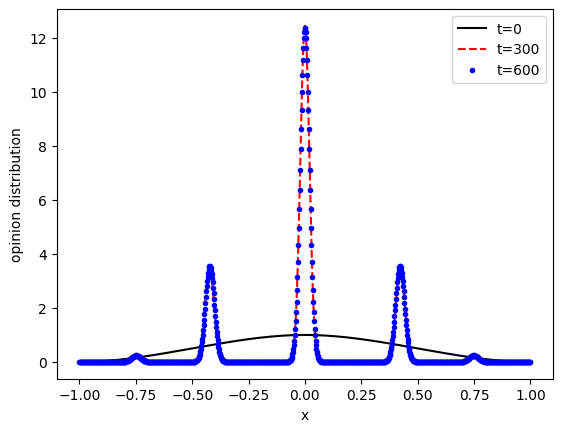

In [2]:
# figure 1
grid=np.linspace(-1,1,int(1e3))
op=opinion()
print('save initial conditions')
X0=op.testrun(100,0, grid=grid)
print('run simulation for T=300')
X1=op.testrun(100,150, T=300, grid=grid)
print('run simulation for T=600')
X2=op.testrun(200,600, T=600, grid=grid)
plt.plot(grid,X0,'k',label='t=0')
plt.plot(grid,X1,'r--',label='t=300')
plt.plot(grid,X2,'b.',label='t=600')
plt.legend()
plt.xlabel('x')
plt.ylabel('opinion distribution')
plt.savefig('Figures/fig1.pdf')
plt.savefig('Figures/fig1.png', dpi=600)

# 2-Candidate Interaction

Candidates met at timestep 242
Candidates met at timestep 249
Candidates separated at timestep 261


<Figure size 640x480 with 0 Axes>

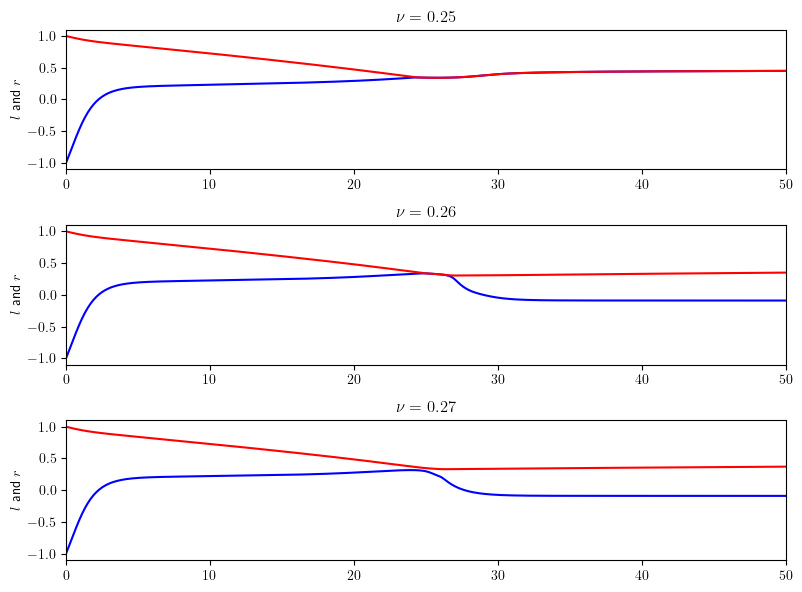

In [3]:
# Figure 2: Varying voter open-mindedness.
op=opinion(nu=0.25, gamma=1)
SL1, SR1, time1 =op.two_candidate_run(100,0.1, T=50, alpha=[1, 0.1], plotit=False)

op.nu=0.26
SL2, SR2, time2 =op.two_candidate_run(100,0.1, T=50, alpha=[1, 0.1], plotit=False)

op.nu=0.27
SL3, SR3, time3 =op.two_candidate_run(100,0.1, T=50, alpha=[1, 0.1], plotit=False)

plt.figure()
plt.rc('text', usetex=True)
plt.figure(figsize=(8, 6))
plt.subplot(3,1,1)
plt.plot(time1,SL1,label='L',color='b')
plt.plot(time1,SR1,label='R',color='r')
plt.xlim(0,50)
plt.title(r'$\nu=0.25$')
plt.ylabel(r'$l$ and $r$')

plt.subplot(3,1,2)
plt.plot(time2,SL2,label='L',color='b')
plt.plot(time2,SR2,label='R',color='r')
plt.xlim(0,50)
plt.title(r'$\nu=0.26$')
#plt.xlabel('time')
plt.ylabel(r'$l$ and $r$')

plt.subplot(3,1,3)
plt.plot(time3,SL3,label='L',color='b')
plt.plot(time3,SR3,label='R',color='r')
plt.xlim(0,50)
plt.title(r'$\nu=0.27$')
#plt.xlabel('time')
plt.ylabel(r'$l$ and $r$')
plt.tight_layout(pad=1.0)

plt.savefig('Figures/fig2.pdf')
plt.savefig('Figures/fig2.png', dpi=600)

Candidates met at timestep 241
Candidates met at timestep 246
Candidates separated at timestep 259


<Figure size 640x480 with 0 Axes>

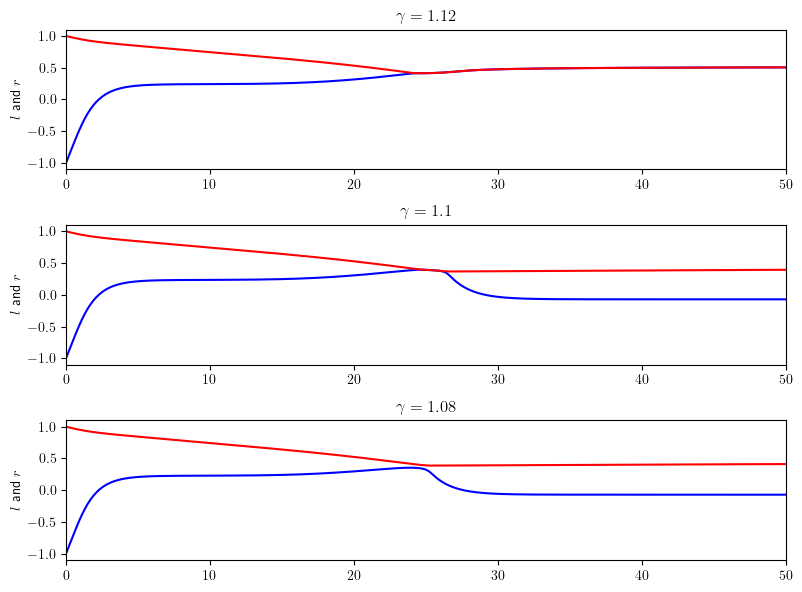

In [4]:
# figure 3: Varying voter loyalty.
op=opinion(nu=0.3, gamma=1.12)
SL1, SR1, time1 =op.two_candidate_run(100,0.1, T=50, alpha=[1, 0.1], plotit=False)

op.gamma=1.1
SL2, SR2, time2 =op.two_candidate_run(100,0.1, T=50, alpha=[1, 0.1], plotit=False)

op.gamma=1.08
SL3, SR3, time3 =op.two_candidate_run(100,0.1, T=50, alpha=[1, 0.1], plotit=False)

plt.figure()
plt.rc('text', usetex=True)
plt.figure(figsize=(8, 6))
plt.subplot(3,1,1)
plt.plot(time1,SL1,label='L',color='b')
plt.plot(time1,SR1,label='R',color='r')
plt.xlim(0,50)
plt.title(r'$\gamma=1.12$')
plt.ylabel(r'$l$ and $r$')

plt.subplot(3,1,2)
plt.plot(time2,SL2,label='L',color='b')
plt.plot(time2,SR2,label='R',color='r')
plt.xlim(0,50)
plt.title(r'$\gamma=1.1$')
#plt.xlabel('time')
plt.ylabel(r'$l$ and $r$')

plt.subplot(3,1,3)
plt.plot(time3,SL3,label='L',color='b')
plt.plot(time3,SR3,label='R',color='r')
plt.xlim(0,50)
plt.title(r'$\gamma=1.08$')
#plt.xlabel('time')
plt.ylabel(r'$l$ and $r$')
plt.tight_layout(pad=1.0)

plt.savefig('Figures/fig3.pdf')
plt.savefig('Figures/fig3.png', dpi=600)


Candidates met at timestep 41
Candidates met at timestep 124
Candidates separated at timestep 147
Candidates met at timestep 300


<Figure size 640x480 with 0 Axes>

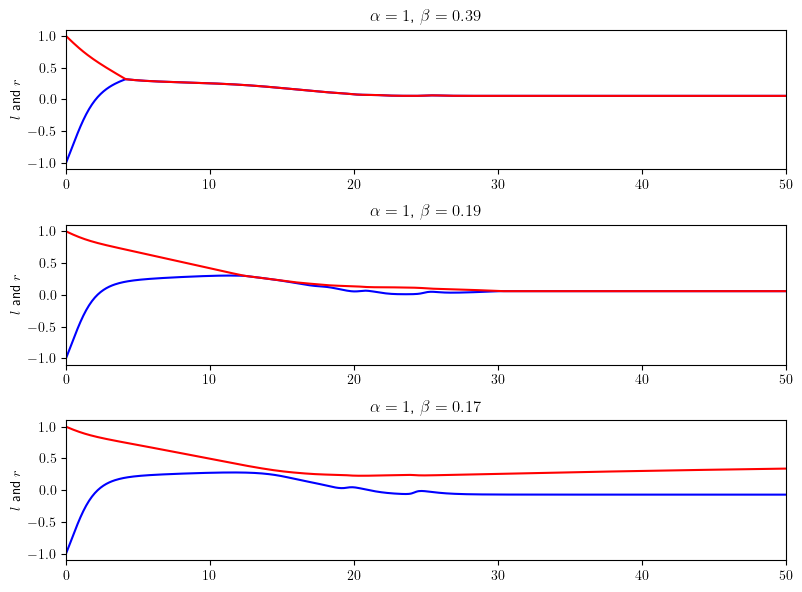

In [5]:
# figure 4: Varying candidate opportunism. 
op=opinion(nu=0.3, gamma=1)
SL1, SR1, time1 =op.two_candidate_run(100,0.1, T=50, alpha=[1, 0.39], plotit=False)
SL2, SR2, time2 =op.two_candidate_run(100,0.1, T=50, alpha=[1, 0.19], plotit=False)
SL3, SR3, time3 =op.two_candidate_run(100,0.1, T=50, alpha=[1, 0.17], plotit=False)


plt.figure()
plt.figure(figsize=(8, 6))
plt.rc('text', usetex=True)
plt.subplot(3,1,1)
plt.plot(time1,SL1,label='L',color='b')
plt.plot(time1,SR1,label='R',color='r')
plt.xlim(0,50)
plt.title(r'$\alpha=1$, $\beta=0.39$')
plt.ylabel(r'$l$ and $r$')

plt.subplot(3,1,2)
plt.plot(time2,SL2,label='L',color='b')
plt.plot(time2,SR2,label='R',color='r')
plt.xlim(0,50)
plt.title(r'$\alpha=1$, $\beta=0.19$')
plt.ylabel(r'$l$ and $r$')

plt.subplot(3,1,3)
plt.plot(time3,SL3,label='L',color='b')
plt.plot(time3,SR3,label='R',color='r')
plt.xlim(0,50)
plt.title(r'$\alpha=1$, $\beta=0.17$')
#plt.xlabel('time')
plt.ylabel(r'$l$ and $r$')
plt.tight_layout(pad=1.0)

plt.savefig('Figures/fig4.pdf')
plt.savefig('Figures/fig4.png', dpi=600)

# 3-Candidate Interaction

LM met at timestep 57
LM separated at timestep 118
MR met at timestep 234
All met at timestep 354
L separated from MR at timestep 574
MR separated at timestep 585
None are together at the end
LM met at timestep 57
LM separated at timestep 118
MR met at timestep 234
All met at timestep 352
All are together at the end


<Figure size 640x480 with 0 Axes>

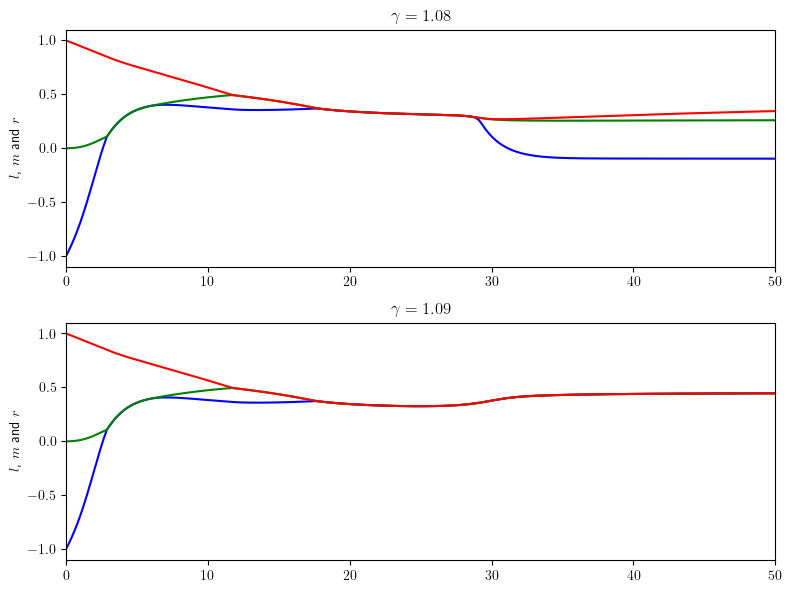

In [6]:
#figure 5: Varying voter loyalty in 3-candidate setting.
op=opinion(nu=0.25, gamma=1.08)
SL1, SM1, SR1, time1 =op.three_candidate_run(100,0.05, T=50, alpha=[1,0.2,0.2], plotit=False)
op.gamma=1.09
SL2, SM2, SR2, time2 =op.three_candidate_run(100,0.05, T=50, alpha=[1,0.2,0.2], plotit=False)

plt.figure()
plt.figure(figsize=(8, 6))
plt.rc('text', usetex=True)
plt.subplot(2,1,1)
plt.plot(time1,SL1,label='L',color='b')
plt.plot(time1,SM1,label='M',color='g')
plt.plot(time1,SR1,label='R',color='r')
plt.xlim(0,50)
plt.title(r'$\gamma=1.08$')
plt.ylabel(r'$l$, $m$ and $r$')

plt.subplot(2,1,2)
plt.plot(time2,SL2,label='L',color='b')
plt.plot(time2,SM2,label='M',color='g')
plt.plot(time2,SR2,label='R',color='r')
plt.xlim(0,50)
plt.title(r'$\gamma=1.09$')
plt.ylabel(r'$l$, $m$ and $r$')
plt.tight_layout(pad=1.0)

plt.savefig('Figures/fig5.pdf')
plt.savefig('Figures/fig5.png', dpi=600)